### Load libraries:

In [19]:
import os
import json
import shutil
import cv2
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
from tqdm.notebook import tqdm
from PIL import Image

### Prepare data:

In [20]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(project_root, "fashion_seg_coco")
IMAGE_DIR = os.path.join(data_dir, "images") 
COCO_ANNOTATION_FILE = os.path.join(data_dir, "result.json")

In [21]:
OUTPUT_DATASET_DIR = "../fashion_sam_dataset_v2"

In [22]:
def create_binary_mask(coco_api, img_info):
    ann_ids = coco_api.getAnnIds(imgIds=img_info['id'])
    if not ann_ids:
        return None
        
    anns = coco_api.loadAnns(ann_ids)
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    
    for ann in anns:
        mask = np.maximum(mask, coco_api.annToMask(ann))
        
    return mask * 255

In [23]:
output_img_dir = os.path.join(OUTPUT_DATASET_DIR, "images")
output_mask_dir = os.path.join(OUTPUT_DATASET_DIR, "masks")
os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

In [25]:
coco = COCO(COCO_ANNOTATION_FILE)
img_ids = coco.getImgIds()
image_info_list = coco.loadImgs(img_ids)

metadata = []

for img_info in tqdm(image_info_list):
    file_name = img_info['file_name']
    base_name = os.path.splitext(file_name)[0]
    
    src_img_path = os.path.join(IMAGE_DIR, file_name)
    
    if not os.path.exists(src_img_path):
        print(f"Warning: Image file not found, skipping: {src_img_path}")
        continue
    
    dst_img_path = os.path.join(output_img_dir, file_name)
    shutil.copy(src_img_path, dst_img_path)
    
    # create the corresponding binary mask
    mask = create_binary_mask(coco, img_info)
    if mask is None or np.max(mask) == 0:
        print(f"Warning: No valid annotations found for {file_name}, skipping.")
        os.remove(dst_img_path) 
        continue
    
    mask_file_name = f"{base_name}_mask.png"
    dst_mask_path = os.path.join(output_mask_dir, mask_file_name)
    cv2.imwrite(dst_mask_path, mask)
    
    metadata.append({
        "imageid": file_name,
        "maskid": mask_file_name,
    })

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


  0%|          | 0/15 [00:00<?, ?it/s]

In [26]:
df = pd.DataFrame(metadata)
manifest_path = os.path.join(OUTPUT_DATASET_DIR, "train.csv")
df.to_csv(manifest_path, index=False)

### Prepare dataset for HF

In [31]:
import datasets
from PIL import Image
HF_REPO_NAME = "peaceAsh/fashion_sam_dataset_v2" 

In [29]:
hf_dataset = datasets.load_dataset('csv', data_files=manifest_path)['train']

def load_image_data(example):
    
    image_path = os.path.join(OUTPUT_DATASET_DIR, example['image_path'])
    example['image'] = Image.open(image_path).convert("RGB")

    mask_path = os.path.join(OUTPUT_DATASET_DIR, example['mask_path'])
    example['mask'] = Image.open(mask_path).convert("L") 
    
    return example

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Dataset loaded into Hugging Face format:
Dataset({
    features: ['image', 'mask'],
    num_rows: 15
})


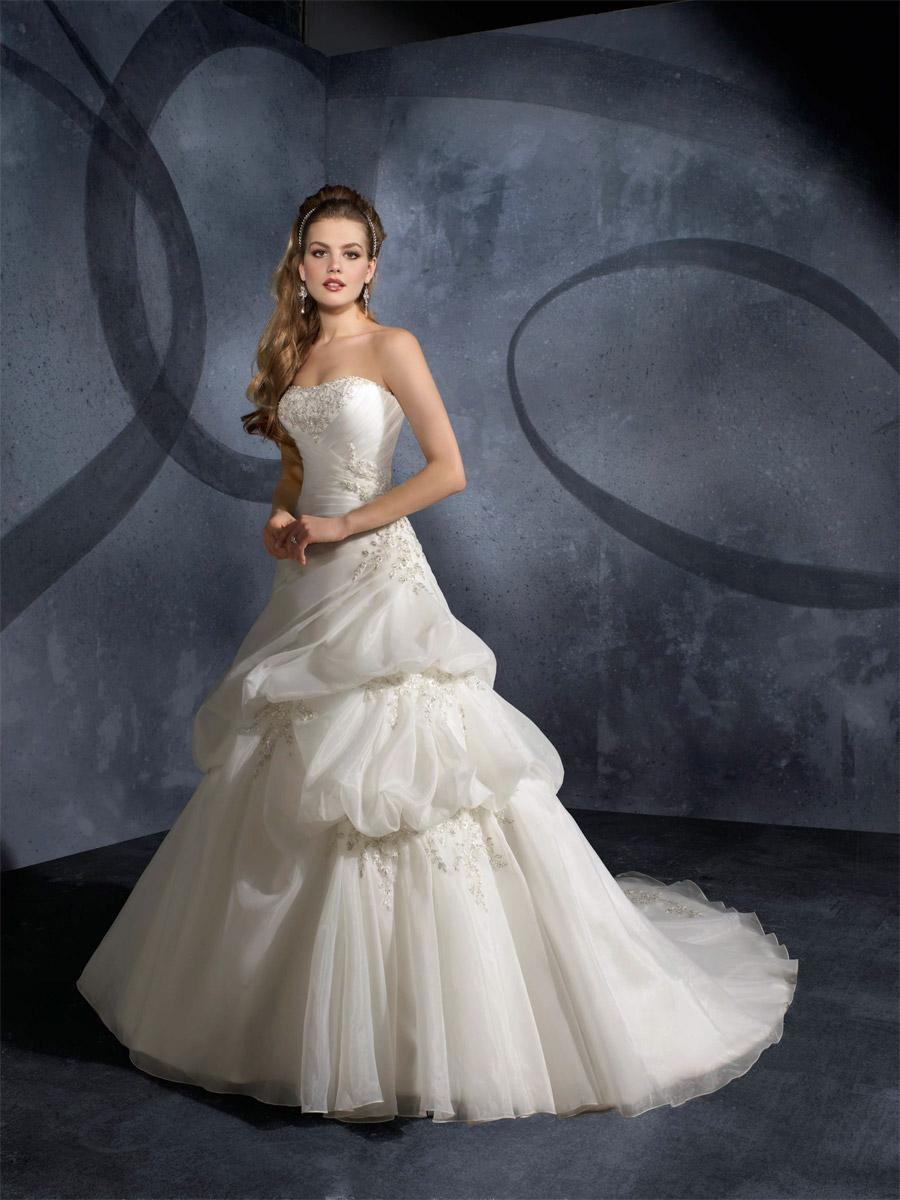

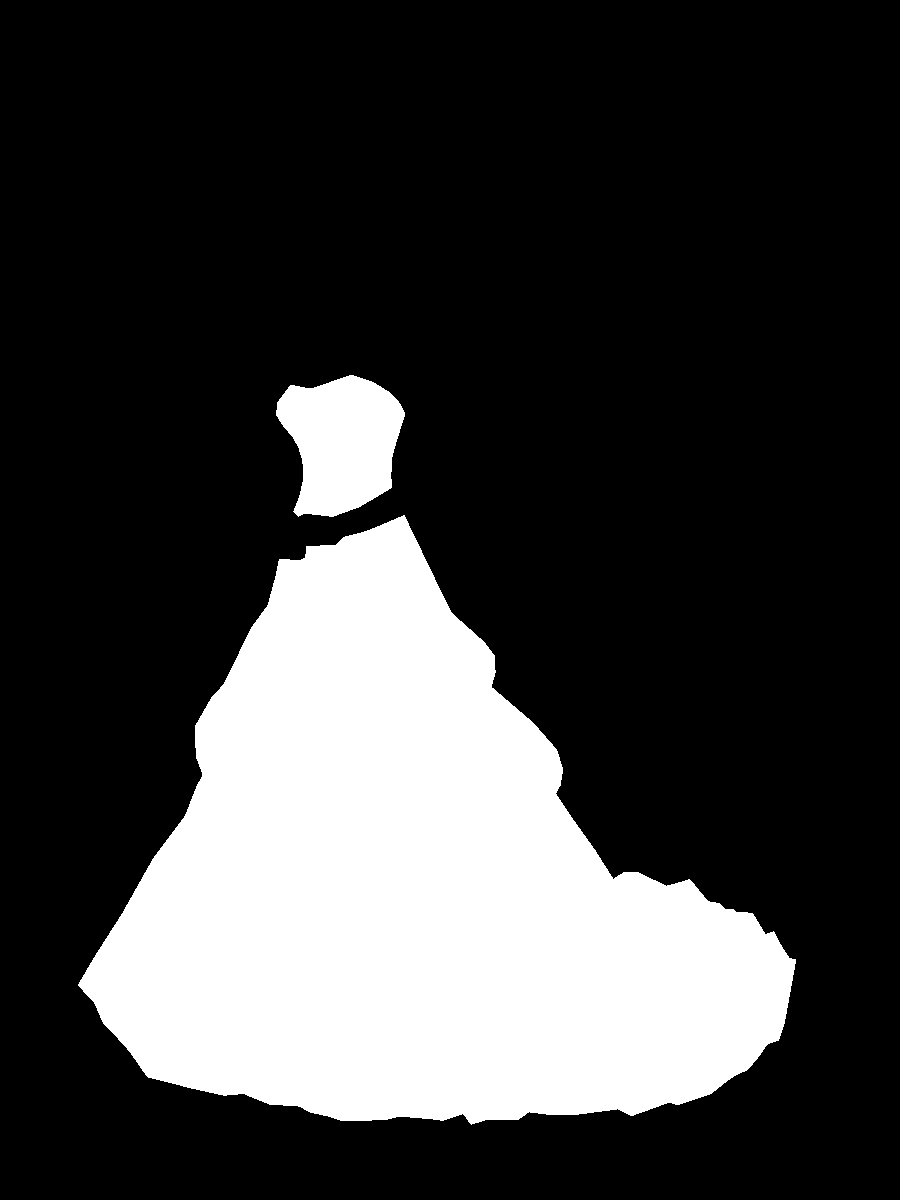

In [27]:
hf_dataset = hf_dataset.map(load_image_data, remove_columns=['image_path', 'mask_path'])

print("Dataset loaded into Hugging Face format:")
print(hf_dataset)

display(hf_dataset[0]['image'])
display(hf_dataset[0]['mask'])


### Upload to Hugging Face:

In [29]:
from huggingface_hub import notebook_login

notebook_login()

In [36]:
from huggingface_hub import HfApi, create_repo, upload_folder

hf_fashion_repo = "peaceAsh/fashion_seg_coco_dataset"

api = HfApi()
create_repo(repo_id=hf_fashion_repo, repo_type="dataset", private=False)
upload_folder(
    folder_path="../fashion_seg_coco",  
    repo_id=hf_fashion_repo,
    repo_type="dataset"
)

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/peaceAsh/fashion_seg_coco_dataset/commit/ae462acee908f450cbf42dd0f9d23fab00f4f040', commit_message='Upload folder using huggingface_hub', commit_description='', oid='ae462acee908f450cbf42dd0f9d23fab00f4f040', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/peaceAsh/fashion_seg_coco_dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='peaceAsh/fashion_seg_coco_dataset'), pr_revision=None, pr_num=None)

In [30]:
#uploading dataset formatted for SAM model
hf_dataset.push_to_hub(HF_REPO_NAME)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/peaceAsh/fashion_sam_dataset_v2/commit/96b3e2ee4e6cea72f162d103ad10543ef655a1a3', commit_message='Upload dataset', commit_description='', oid='96b3e2ee4e6cea72f162d103ad10543ef655a1a3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/peaceAsh/fashion_sam_dataset_v2', endpoint='https://huggingface.co', repo_type='dataset', repo_id='peaceAsh/fashion_sam_dataset_v2'), pr_revision=None, pr_num=None)